the data we are interested in is VALENCE.PLEASANTNESS, wich take values between 0 and 100. The objective is to create a model estimating the VALENCE.PLEASANTNESS given the inputs "Intensity, "SWEETORSOUR"(sure?), and V2 to V11787, which represent the presence or not of a corresponding physiochemical feature in the smelled molecule. At first sight of the data plotted above, we can see that the SWEETORSOUR variable seems have a relatively big impact on VALENCE.PLEASANTNESS (actually it does not proves anything, it is just an early observation). Now we look at some randomly chosen physiochemical features comparing the means of VALENCE.PLEASANTNESS when they are present or not.:

In [3]:
#check the means with or without some randomly chosen physiochemical features
for(col in sample(2:nrow(data),7)){
    idx.presence<-c()
    idx.nonpresence<-c()
    for(i in 1:nrow(data)){
        if(data[col,i]==1){
            idx.presence<-append(idx.presence,i)
        }else{
            idx.nonpresence<-append(idx.nonpresence,i)
        }
    }
    #message("presence mean of ", colnames(data)[col]," ",mean(data$VALENCE.PLEASANTNESS[idx.presence]))
    #message("nonpresence mean ",colnames(data)[col]," ",mean(data$VALENCE.PLEASANTNESS[idx.nonpresence]))
}

Now, Let's start to create a basic linear regression model on all the data. This model will be the base to be improved to try and get the best linear model. We separate all the data in a training set (2/3 of the whole data is taken as training set because we will separate it in a validation and actual training set later).

In [31]:
#create a training (for now, it will be split later) and test set.
idx.train<-sample(nrow(data),nrow(data)*(2/3))
data.test<-data[-idx.train,]
data<-data[idx.train,]

the next cell is really slow, because of all the predictors (11789 !!!), and since p>>n we will largely overfit the data.

In [6]:
basic.lm.fit<-lm(VALENCE.PLEASANTNESS~.,data=data)

In [14]:
train.pred<-predict(basic.lm.fit,data=data)
test.pred<-predict(basic.lm.fit,data=data.test)
trainMSE<-mean((data$VALENCE.PLEASANTNESS-train.pred)^2)
testMSE<-mean((data.test$VALENCE.PLEASANTNESS-test.pred)^2)
cat("train MSE: ",trainMSE, "\n")
cat("test MSE: ",testMSE)

#summary(basic.lm.fit)    


ERROR: Error in predict(basic.lm.fit, data = data): objet 'basic.lm.fit' introuvable


We can see that, as predicted, we largely overfit the data when using all predictors for linear regression. Also, consequently to p>>n, a large part of the predictors parameters are NAs. We will use cross validation to try and get the number of predictors that gives the lowest validation error.

In [15]:
library(tidymodels)
library(leaps)

In [32]:
#testing cell
validation.data<-vfold_cv(data, v=5)
fit<-regsubsets(VALENCE.PLEASANTNESS~.,data, method="forward", nvmax=20)

Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
"11487  linear dependencies found"


Reordering variables and trying again:


ERROR: Error in leaps.setup(x[, ii[reorder], drop = FALSE], y, wt, force.in[reorder], : NA/NaN/Inf dans un appel à une fonction externe (argument 4)


In [8]:
validation.data<-vfold_cv(data, v=5)

cv_fit_and_eval <- function(fold, formula=VALENCE.PLEASANTNESS ~ .) {
    fit<-regsubsets(formula, analysis(fold), method="forward", nvmax=30)
    validation.set<-assessment(fold)
    sapply(seq(1,fit$nvmax-1),
           function(idx) fitmean(validation.set$VALENCE.PLEASANTNESS-predict(fit,validation.set,idx,formula)^2))
    str(fit)
}
cv.errors<-sapply(validation.data$splits,cv_fit_and_eval)

Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
"11519  linear dependencies found"


Reordering variables and trying again:


ERROR: Error in leaps.setup(x[, ii[reorder], drop = FALSE], y, wt, force.in[reorder], : NA/NaN/Inf dans un appel à une fonction externe (argument 4)


In [70]:
fits<-regsubsets(VALENCE.PLEASANTNESS~., data, method = "forward", nvmax=30)

Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
"2700  linear dependencies found"


Reordering variables and trying again:


In [76]:
predict.regsubsets <- function(object, newdata, id, form = as.formula(object$call[[2]])) {
    mat = model.matrix(form, newdata)
    coefi = coef(object, id=id)
    xvars = names(coefi)
    mat[,xvars]%*%coefi
}                                    #using predict formula defined in Lecture 4

In [78]:
fit.and.eval<-function(fold,formula = VALENCE.PLEASANTNESS ~ .) {
    fit<-regsubsets(formula, analysis(fold), nvmax=30, method = 'forward')
    valid.set<-assessment(fold)
    sapply(1:(fit$nvmax-1),
          function(nb) mean((valid.set$VALENCE.PLEASANTNESS - predict(fit, valid.set, nb, formula))^2))
}
validation.data<-vfold_cv(data,v=5)
cv.errors<-sapply(validation.data$splits, fit.and.eval)
head(cv.errors)


Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
"2710  linear dependencies found"


Reordering variables and trying again:


Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
"2711  linear dependencies found"


Reordering variables and trying again:


Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
"2708  linear dependencies found"


Reordering variables and trying again:


Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
"2712  linear dependencies found"


Reordering variables and trying again:


Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
"2709  linear dependencies found"


Reordering variables and trying again:


253.2524,350.4810,295.1347,349.3675,329.1570
256.7313,358.4596,280.5217,351.1872,322.3044
256.5084,367.3672,319.5868,349.1995,324.1539
262.6435,362.4751,326.9709,355.6666,325.4438
263.9150,358.9280,318.6749,344.6454,318.3929
257.9440,357.2943,307.0730,335.7402,307.3385


In [82]:
head(cv.errors,10)
which.min(rowMeans(cv.errors))

253.2524,350.4810,295.1347,349.3675,329.1570
256.7313,358.4596,280.5217,351.1872,322.3044
256.5084,367.3672,319.5868,349.1995,324.1539
262.6435,362.4751,326.9709,355.6666,325.4438
263.9150,358.9280,318.6749,344.6454,318.3929
257.9440,357.2943,307.0730,335.7402,307.3385
255.4004,356.0790,314.7202,336.8180,302.0043
265.9355,363.2667,311.2241,331.1116,301.1186
263.6568,360.2667,316.6011,333.9795,299.3935
266.3011,360.9370,323.9093,336.1302,303.3486


[1] 7

In [76]:
pred.to.rm<-apply(max.cor.pred,1,function(x) x[1])
length(pred.to.rm)
pred.to.rm<-pred.to.rm[!duplicated(pred.to.rm)]
typeof(pred.to.rm)
pred.to.rm


[1] 1931

[1] "character"

[1] "87"      "526"     "699"     "1822"    "2072"    "2625"    "3078"   
  [8] "8773"    "8793"    "10731"   "10878"   "11026"   "11175"   "11316"  
 [15] "11386"   "12402"   "12712"   "16081"   "21003"   "24753"   "26334"  
 [22] "29146"   "30606"   "38776"   "39055"   "40487"   "41316"   "41712"  
 [29] "43951"   "44348"   "44848"   "45148"   "45751"   "46054"   "46663"  
 [36] "46961"   "47585"   "47586"   "47895"   "48205"   "49427"   "50058"  
 [43] "51675"   "52320"   "57613"   "57917"   "58294"   "59336"   "62830"  
 [50] "63185"   "64413"   "67140"   "67502"   "67870"   "71592"   "71622"  
 [57] "73148"   "73531"   "73919"   "74465"   "74681"   "75466"   "75611"  
 [64] "76245"   "77313"   "77751"   "77788"   "78183"   "78589"   "82210"  
 [71] "83434"   "83843"   "84664"   "85076"   "85903"   "86310"   "87152"  
 [78] "87153"   "87571"   "87990"   "89648"   "90497"   "95695"   "97015"  
 [85] "97456"   "98341"   "99681"   "100128"  "100576"  "102350"  "103257" 
 [92] "107411"  "107880"  "109276"  "109744"  "110683"  "111154"  "112099" 
 [99] "114002"  "114003"  "114481"  "114960"  "116856"  "117825"  "118311" 
[106] "118798"  "119302"  "119775"  "121741"  "122260"  "122760"  "123232" 
[113] "123723"  "124249"  "124748"  "125220"  "125749"  "126251"  "126726" 
[120] "127258"  "127735"  "128245"  "129285"  "129286"  "129795"  "130305" 
[127] "130786"  "131298"  "131811"  "132325"  "132840"  "133356"  "138070" 
[134] "138601"  "140183"  "140713"  "141776"  "142309"  "143378"  "144441" 
[141] "145529"  "146069"  "146070"  "146611"  "148755"  "149848"  "150365" 
[148] "154841"  "155403"  "156459"  "157078"  "157639"  "158764"  "159328" 
[155] "160459"  "161584"  "162734"  "163305"  "163306"  "163878"  "165339" 
[162] "165539"  "166146"  "166692"  "167301"  "172573"  "173166"  "174934" 
[169] "175526"  "176713"  "177308"  "178501"  "180887"  "180900"  "181502" 
[176] "182105"  "184498"  "185715"  "186294"  "187533"  "191266"  "191890" 
[183] "193070"  "193751"  "194374"  "194939"  "195623"  "196249"  "196817" 
[190] "197504"  "198753"  "200027"  "200601"  "200660"  "200661"  "201295" 
[197] "203142"  "203811"  "204419"  "205090"  "223417"  "223842"  "224756" 
[204] "228422"  "228797"  "232192"  "232211"  "236320"  "239084"  "243922" 
[211] "244621"  "245332"  "249542"  "255226"  "255941"  "260279"  "264569" 
[218] "265327"  "266056"  "266786"  "269686"  "271187"  "274901"  "277856" 
[225] "287632"  "288391"  "289162"  "289882"  "290644"  "292171"  "293732" 
[232] "294469"  "295237"  "296006"  "297547"  "299092"  "299866"  "300671" 
[239] "301387"  "301417"  "302194"  "304531"  "305369"  "309232"  "310019" 
[246] "310837"  "311626"  "312416"  "318927"  "319600"  "334942"  "335761" 
[253] "336581"  "412679"  "660713"  "662972"  "666432"  "667587"  "671052" 
[260] "672217"  "673373"  "674534"  "675696"  "676849"  "680353"  "682688" 
[267] "755806"  "768171"  "771480"  "783117"  "784369"  "785630"  "786884" 
[274] "788139"  "789395"  "790652"  "791910"  "792072"  "792244"  "802010" 
[281] "804545"  "805814"  "807084"  "808355"  "809627"  "817276"  "817280" 
[288] "818559"  "819839"  "821120"  "822402"  "823685"  "824969"  "826254" 
[295] "827540"  "827712"  "837864"  "839159"  "840455"  "841752"  "843050" 
[302] "844349"  "845649"  "853470"  "854777"  "856085"  "857394"  "858704" 
[309] "860015"  "861327"  "862640"  "863954"  "874502"  "877149"  "878474" 
[316] "879800"  "881127"  "882455"  "885059"  "890445"  "891780"  "893116" 
[323] "894453"  "895791"  "897130"  "898470"  "899811"  "901153"  "910575" 
[330] "911772"  "932132"  "952717"  "959771"  "961157"  "962544"  "963932" 
[337] "965321"  "966711"  "968102"  "969494"  "970887"  "972281"  "973676" 
[344] "975072"  "976469"  "977867"  "979266"  "980666"  "982067"  "983469" 
[351] "984872"  "986276"  "987681"  "989087"  "990494"  "991902"  "993311" 
[358] "994721"  "996132"  "997544"  "998957"  "1000371" "1001786" "1003202"
[365] "1004619" "1006037" "1007456" "1022947" "104

In [162]:
nn1<-keras_model_sequential()
nn1 %>%
    layer_dense(units=10, activation='relu', input_shape = c(1855), name = 'dense_input') %>%
    layer_dense(units=20, activation='relu',name = 'dense_2') %>%
    layer_dense(units=1, activation='linear', name = 'dense_output')
summary(nn1)

Model: "sequential_33"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
dense_input (Dense)                 (None, 10)                      18560       
________________________________________________________________________________
dense_2 (Dense)                     (None, 20)                      220         
________________________________________________________________________________
dense_output (Dense)                (None, 1)                       21          
Total params: 18,801
Trainable params: 18,801
Non-trainable params: 0
________________________________________________________________________________


In [595]:
nn2 %>% compile(loss='MSE',optimizer='adam')

In [596]:
nn2 %>% fit(as.matrix(data[,-1]),
                    data[,1],
                    epochs=100)

In [597]:
pred<-predict(nn2,as.matrix(data.final.test))

In [598]:
pred.sub<-cbind(which(pred==pred),pred)
colnames(pred.sub)<-c("id","VALENCE.PLEASANTNESS")

In [599]:
head(pred.sub,20)

id,VALENCE.PLEASANTNESS
1,38.73025
2,67.88890
3,45.65573
4,49.46078
5,36.78001
6,56.23206
7,39.44513
8,55.63501
9,46.92269
10,54.15268


In [600]:
write.csv(pred.sub,"submisson_nn_10_10_1.csv", row.names=F)

In [665]:
set.seed(1)
nn2<-keras_model_sequential()
nn2 %>%
    layer_dense(units=10, activation='relu', input_shape = c(1855), name = 'dense_input') %>%
    layer_dense(units=10, activation='relu', name = 'dense_2') %>%
    #layer_dense(units=10, activation='relu', name = 'dense_3') %>%
    #layer_dense(units=10, activation='relu', name = 'dense_4') %>%
    #layer_dense(units=200, activation='relu', kernel_regularizer =regularizer_l2(l=0.1), name = 'dense_5') %>%
    #layer_dense(units=200, activation='relu', kernel_regularizer =regularizer_l2(l=0.1), name = 'dense_6') %>%
    #layer_dense(units=200, activation='relu', kernel_regularizer =regularizer_l2(l=0.1), name = 'dense_7') %>%
    #layer_dense(units=200, activation='relu', kernel_regularizer =regularizer_l2(l=0.1), name = 'dense_8') %>%
    #layer_dropout(rate = .0) %>%
    layer_dense(units=1, activation='linear', name = 'dense_output')
summary(nn2)

Model: "sequential_11"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
dense_input (Dense)                 (None, 10)                      18560       
________________________________________________________________________________
dense_2 (Dense)                     (None, 10)                      110         
________________________________________________________________________________
dense_output (Dense)                (None, 1)                       11          
Total params: 18,681
Trainable params: 18,681
Non-trainable params: 0
________________________________________________________________________________


In [282]:
get.scale <- function(scaled) {
    if ("scaled:center" %in% names(attributes(scaled))) {
        center <- attr(scaled, "scaled:center")
    } else {
        center <- rep(0, ncol(scaled))
    }
    if ("scaled:scale" %in% names(attributes(scaled))) {
        list(center, attr(scaled, "scaled:scale"))
    } else {
        list(center, rep(1., length(center)))
    }
}
data.x.scale <- function(x, scaled) {
    s <- get.scale(scaled)
    centered <- sweep(x, 2, s[[1]])
    sweep(centered, 2, s[[2]], FUN = "/")
}
data.y.scale <- function(y, scaled) {
    s <- get.scale(scaled)
    (y - s[[1]])/s[[2]]
}
data.y.unscale <- function(y, scaled) {
    s <- get.scale(scaled)
    y * s[[2]] + s[[1]]
}
keras.func <- function (seed = 1,nn) {
        tensorflow::tf$random$set_seed(seed)
        data.train.x.prep <- as.matrix(scale(data.train.x, center = T, scale = T))
        data.train.y.prep <- scale(data.train.y, center = T, scale = T)
        nn %>% compile(optimizer = "adam", loss = "mean_squared_error")
        history <- nn %>% fit(data.train.x.prep,
                             data.train.y.prep,
                             verbose = 0,
                             batch_size = length(data.train.y.prep),
                             validation_split = 0.1,
                            epochs = 500)
        nn.pred <- predict(nn, as.matrix(data.x.scale(data.test.x, data.train.x.prep)))
        mean((data.y.unscale(nn.pred, data.train.y.prep) - data.test.y)^2)
    
}
keras.func(2,nn2)
#keras.res <- sapply(1:2, keras.func,nn2)

[1] NaN

`geom_smooth()` using formula 'y ~ x'



loss 
0.2764146

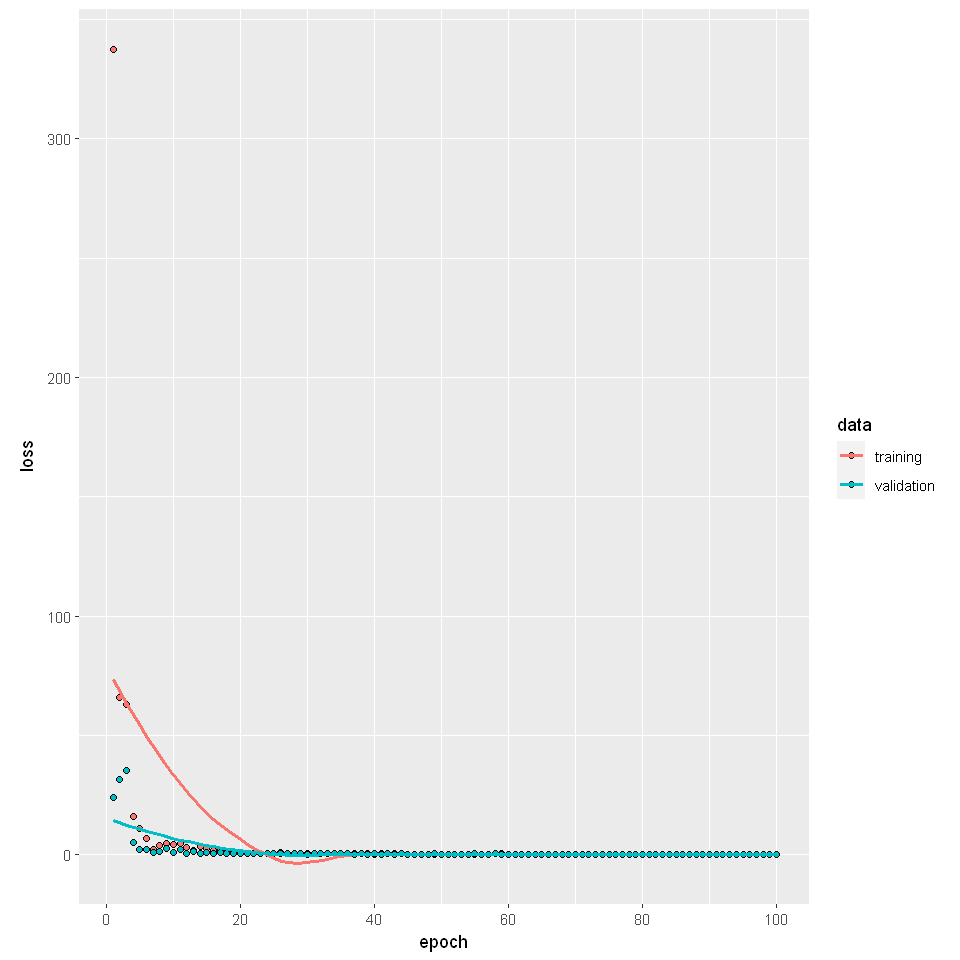

In [256]:
tensorflow::tf$random$set_seed(4)
history2<-compile_and_fit(nn2,
                          data.y=data.train.y.scaled,valid.split=0.1)
plot(history2)
evaluate(nn2,as.matrix(data.test.x),data.test.y.scaled)

In [224]:
tensorflow::tf$random$set_seed(2)
nn2 %>% compile(loss='MSE',optimizer='adam')

In [226]:
verifH<-nn2 %>% fit(as.matrix(data[,-1]),
                    data[,1],
                    epochs=100,
                    callbacks=callback_early_stopping(monitor='val_loss',patience = 20))

In [230]:
pred<-predict(nn2,as.matrix(data.final.test))

In [231]:
pred.sub<-cbind(which(pred==pred),pred)
colnames(pred.sub)<-c("id","VALENCE.PLEASANTNESS")

In [232]:
head(pred.sub,20)

id,VALENCE.PLEASANTNESS
1,42.70423
2,60.12391
3,47.28643
4,52.46857
5,27.02774
6,60.73274
7,37.09969
8,52.58574
9,58.57777
10,50.08640


In [233]:
write.csv(pred.sub,"submisson_nn_30_20_d01_20_10_1.csv", row.names=F)

[1] 0.1704376

We first build a very network simple, without any regularisation.

In [282]:
nn1<-keras_model_sequential()
nn1 %>%
    layer_dense(units=10, activation='relu', input_shape = c(1855), name = 'dense_input') %>%
    layer_dense(units=10, activation='relu',name = 'dense_2') %>%
    layer_dense(units=1, activation='linear', name = 'dense_output')
summary(nn1)

Model: "sequential_73"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
dense_input (Dense)                 (None, 10)                      18560       
________________________________________________________________________________
dense_2 (Dense)                     (None, 10)                      110         
________________________________________________________________________________
dense_output (Dense)                (None, 1)                       11          
Total params: 18,681
Trainable params: 18,681
Non-trainable params: 0
________________________________________________________________________________


We write a function for compiling and fitting a neural network.

In [162]:
nn1<-keras_model_sequential()
nn1 %>%
    layer_dense(units=10, activation='relu', input_shape = c(1855), name = 'dense_input') %>%
    layer_dense(units=20, activation='relu',name = 'dense_2') %>%
    layer_dense(units=1, activation='linear', name = 'dense_output')
summary(nn1)

Model: "sequential_33"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
dense_input (Dense)                 (None, 10)                      18560       
________________________________________________________________________________
dense_2 (Dense)                     (None, 20)                      220         
________________________________________________________________________________
dense_output (Dense)                (None, 1)                       21          
Total params: 18,801
Trainable params: 18,801
Non-trainable params: 0
________________________________________________________________________________


`geom_smooth()` using formula 'y ~ x'



loss 
465.6259

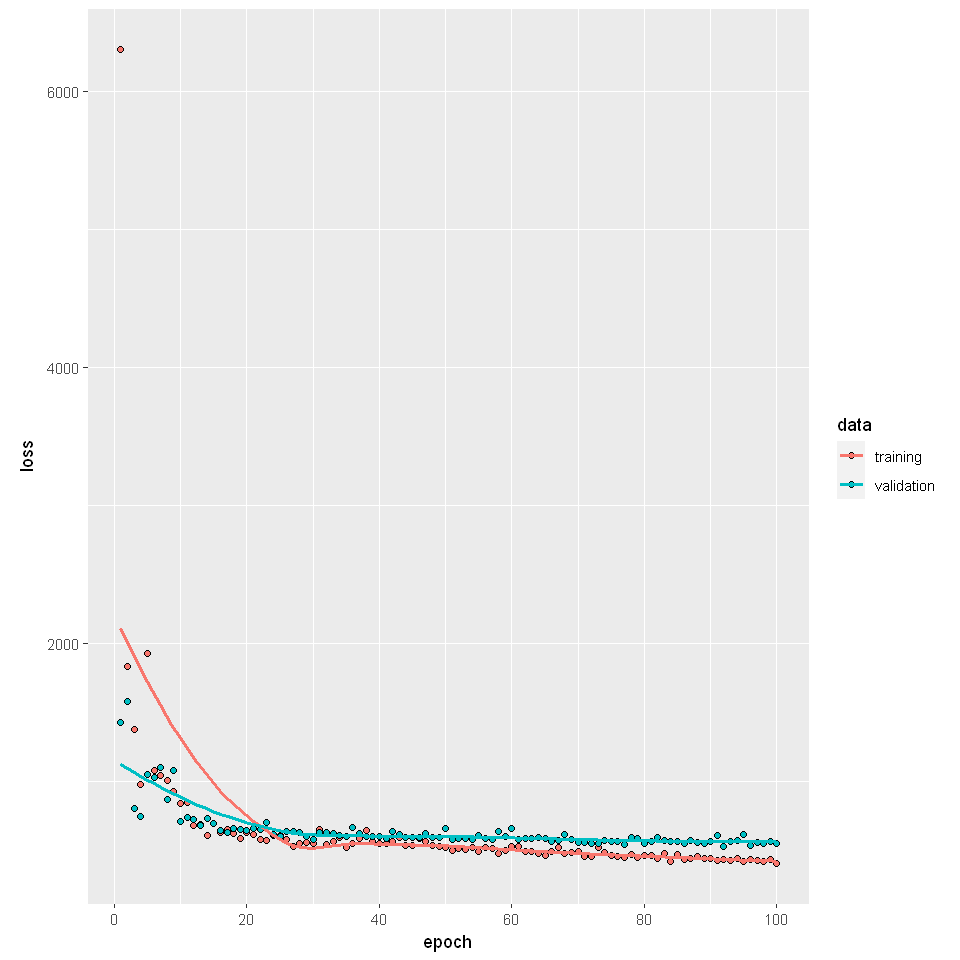

In [216]:
tensorflow::tf$random$set_seed(1)
history.stop<-compile_and_fit(nn,valid.split=0.1,
                               callbacks=callback_early_stopping(monitor='val_loss',patience = 20))
history.stop$params$epochs<-length(history2.stop$metrics$loss)
plot(history.stop)
evaluate(nn,as.matrix(data.test.x),data.test.y)

In [40]:
nn1<-keras_model_sequential()
    nn1 %>%
#        layer_dense(units=50, activation='relu', input_shape = c(1855), name = 'dense_input') %>%
 #       layer_dense(units=20, activation='relu', name = 'dense_1') %>%
  #      layer_dense(units=10, activation='relu', name = 'dense_2') %>%
   #     layer_dense(units=10, activation='relu', name = 'dense_3') %>%
        layer_dense(units=40, activation='relu', input_shape = c(1855), name = 'dense_input') %>%
        layer_dense(units=20, activation='relu', name = 'dense_2') %>%
        layer_dropout(rate=.1)%>%
        layer_dense(units=20, activation='relu', name = 'dense_3') %>%
        layer_dense(units=10, activation='relu', name = 'dense_4') %>%
        layer_dense(units=10, activation='relu', name = 'dense_5') %>%
        layer_dense(units=10, activation='relu', name = 'dense_6') %>%
        layer_dense(units=1, activation='linear', name = 'dense_output')
    

In [212]:
keras.nn.scale<-function(seed,valid.data=NULL,callbacks=NULL){
    tensorflow::tf$random$set_seed(seed)
    data.train.x.nozerovar<-as.matrix(data.train.x[,!sapply(data.train.x,function(x) var(x)==0)])
    print(dim(data.train.x.nozerovar))
    data.train.x.scaled<-scale(data.train.x.nozerovar)
    print(dim(data.train.x.scaled))
    data.train.y.scaled<-scale(data.train.y, center=T,scale=T)
    nn<-keras_model_sequential()
    nn %>%
        layer_dense(units=60, activation='relu', input_shape = c(1850), name = 'dense_input') %>%
        layer_dense(units=80, activation='relu', name = 'dense_2') %>%
        layer_dropout(rate=.1)%>%
        layer_dense(units=50, activation='relu', name = 'dense_3') %>%
        layer_dropout(rate=.1)%>%
        layer_dense(units=20, activation='relu', name = 'dense_4') %>%
        layer_dense(units=10, activation='relu', name = 'dense_5') %>%
        layer_dense(units=10, activation='relu', name = 'dense_6') %>%
        layer_dense(units=1, activation='linear', name = 'dense_output')
    hist<-compile_and_fit(nn,
                        data.x=data.train.x.scaled,
                        data.y=data.train.y.scaled,
                        valid.split=0.1,
                        #valid.data=list(data.x.scale(as.matrix(data.test.x),data.train.x.scaled),
                             #data.y.scale(data.test.y,data.train.y.scaled)),
                        callbacks=callbacks)

    ifelse(callbacks == NULL,,hist$params$epochs<-length(hist$metrics$loss))
    if(seed==2)print(plot(hist))
    nn.pred<-predict(nn,as.matrix(data.test.x))
    print(head(nn.pred))
    mean((data.y.unscale(nn.pred,data.train.y.scaled) - data.test.y)^2)
}

In [213]:
keras.res.scale<-keras.nn.scale(90)
cat(' RMSE mean on the test set over ',d,' different seeds, using scaled data : ',sqrt(mean(keras.res.scale)))

[1]  472 1850
[1]  472 1850
[1]  472 1850


ERROR: Error in py_call_impl(callable, dots$args, dots$keywords): ValueError: in user code:

    C:\Users\totol\ANACON~1\lib\site-packages\tensorflow\python\keras\engine\training.py:1462 predict_function  *
        return step_function(self, iterator)
    C:\Users\totol\ANACON~1\lib\site-packages\tensorflow\python\keras\engine\training.py:1452 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\totol\ANACON~1\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\totol\ANACON~1\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\totol\ANACON~1\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\totol\ANACON~1\lib\site-packages\tensorflow\python\keras\engine\training.py:1445 run_step  **
        outputs = model.predict_step(data)
    C:\Users\totol\ANACON~1\lib\site-packages\tensorflow\python\keras\engine\training.py:1418 predict_step
        return self(x, training=False)
    C:\Users\totol\ANACON~1\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:975 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs,
    C:\Users\totol\ANACON~1\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:212 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer sequential_71 is incompatible with the layer: expected axis -1 of input shape to have value 1850 but received input with shape [None, 1855]


Detailed traceback: 
  File "C:\Users\totol\ANACON~1\lib\site-packages\tensorflow\python\keras\engine\training.py", line 130, in _method_wrapper
    return method(self, *args, **kwargs)
  File "C:\Users\totol\ANACON~1\lib\site-packages\tensorflow\python\keras\engine\training.py", line 1599, in predict
    tmp_batch_outputs = predict_function(iterator)
  File "C:\Users\totol\ANACON~1\lib\site-packages\tensorflow\python\eager\def_function.py", line 780, in __call__
    result = self._call(*args, **kwds)
  File "C:\Users\totol\ANACON~1\lib\site-packages\tensorflow\python\eager\def_function.py", line 823, in _call
    self._initialize(args, kwds, add_initializers_to=initializers)
  File "C:\Users\totol\ANACON~1\lib\site-packages\tensorflow\python\eager\def_function.py", line 696, in _initialize
    self._stateful_fn._get_concrete_function_internal_garbage_collected(  # pylint: disable=protected-access
  File "C:\Users\totol\ANACON~1\lib\site-packages\tensorflow\python\eager\function.py", line 2855, in _get_concrete_function_internal_garbage_collected
    graph_function, _, _ = self._maybe_define_function(args, kwargs)
  File "C:\Users\totol\ANACON~1\lib\site-packages\tensorflow\python\eager\function.py", line 3213, in _maybe_define_function
    graph_function = self._create_graph_function(args, kwargs)
  File "C:\Users\totol\ANACON~1\lib\site-packages\tensorflow\python\eager\function.py", line 3065, in _create_graph_function
    func_graph_module.func_graph_from_py_func(
  File "C:\Users\totol\ANACON~1\lib\site-packages\tensorflow\python\framework\func_graph.py", line 986, in func_graph_from_py_func
    func_outputs = python_func(*func_args, **func_kwargs)
  File "C:\Users\totol\ANACON~1\lib\site-packages\tensorflow\python\eager\def_function.py", line 600, in wrapped_fn
    return weak_wrapped_fn().__wrapped__(*args, **kwds)
  File "C:\Users\totol\ANACON~1\lib\site-packages\tensorflow\python\framework\func_graph.py", line 973, in wrapper
    raise e.ag_error_metadata.to_exception(e)



In [29]:
get.scale <- function(scaled) {
    if ("scaled:center" %in% names(attributes(scaled))) {
        center <- attr(scaled, "scaled:center")
    } else {
        center <- rep(0, ncol(scaled))
    }
    if ("scaled:scale" %in% names(attributes(scaled))) {
        list(center, attr(scaled, "scaled:scale"))
    } else {
        list(center, rep(1., length(center)))
    }
}
data.x.scale <- function(x, scaled) {
    s <- get.scale(scaled)
    centered <- sweep(x, 2, s[[1]])
    sweep(centered, 2, s[[2]], FUN = "/")
}
data.y.scale <- function(y, scaled) {
    s <- get.scale(scaled)
    (y - s[[1]])/s[[2]]
}
data.y.unscale <- function(y, scaled) {
    s <- get.scale(scaled)
    y * s[[2]] + s[[1]]
}